In [3]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [4]:
data = pd.read_csv("weatherHistory.csv")
data.head()

,Formatted Date,Summary,Precip Type,Temperature,Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251,15.8263,0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259,15.8263,0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204,14.9569,0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269,15.8263,0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259,15.8263,0,1016.51,Partly cloudy throughout the day.


In [5]:
#Format the date time index as specified
data['Formatted Date'] = pd.to_datetime(data['Formatted Date'], format = '%Y-%m-%d %H:%M:%S.%f %z')
#Sort in increasing order of date-time
data = data.sort_values('Formatted Date')
data.set_index(data['Formatted Date'], drop = True, inplace = True)
data.drop('Formatted Date', axis = 1, inplace = True)
#Select the prediction column from the dataframe
data = data[['Temperature']]
#Remove duplicated values in index
data = data[~data.index.duplicated()]
#Hourly frequency
data = data.asfreq('H')
#Fill empty/missing values
data = data.fillna(method = 'ffill')
print(data)

                           Temperature
Formatted Date                        
2006-01-01 00:00:00+01:00     0.577778
2006-01-01 01:00:00+01:00     1.161111
2006-01-01 02:00:00+01:00     1.666667
2006-01-01 03:00:00+01:00     1.711111
2006-01-01 04:00:00+01:00     1.183333
...                                ...
2016-12-31 19:00:00+01:00     0.488889
2016-12-31 20:00:00+01:00     0.072222
2016-12-31 21:00:00+01:00    -0.233333
2016-12-31 22:00:00+01:00    -0.472222
2016-12-31 23:00:00+01:00    -0.677778

[96432 rows x 1 columns]


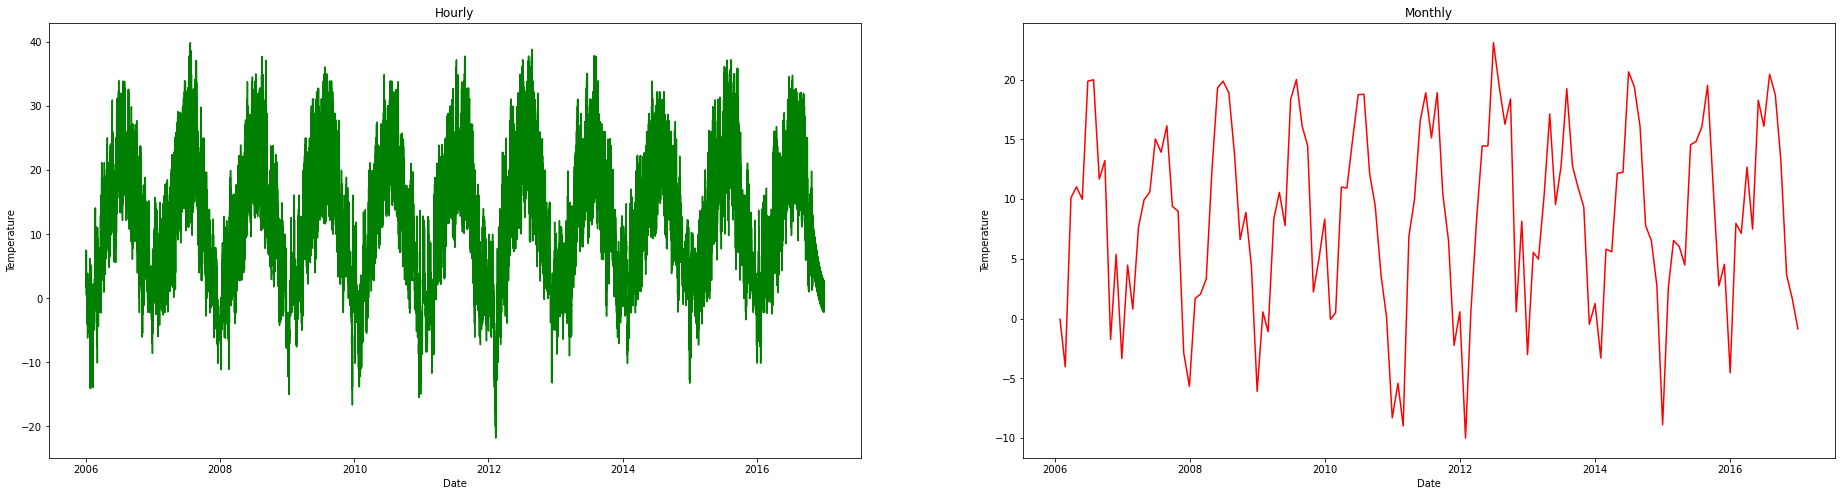

In [6]:
#visualisation
plt.figure(figsize=(32, 8))
plt.subplot(1, 2, 1)
plt.title('Hourly')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(data, color = 'green')
plt.subplot(1, 2, 2)
#Monthly frequency
data = data.asfreq('M')
plt.title('Monthly')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.plot(data, color = 'red')
plt.show()

In [7]:
data_final = data
scaler = MinMaxScaler()
data_final.loc[:, ['Temperature']] = scaler.fit_transform(data_final.loc[:, ['Temperature']])
data_final.head()

,Temperature
Formatted Date,
2006-01-31 00:00:00+01:00,0.300252
2006-02-28 00:00:00+01:00,0.180185
2006-03-31 00:00:00+01:00,0.608060
2006-04-30 00:00:00+01:00,0.635432
2006-05-31 00:00:00+01:00,0.603862


In [8]:
#Train - Test split
train_len = round(len(data_final) * 0.7)
training_data = data_final[:train_len]
training_data.head()

,Temperature
Formatted Date,
2006-01-31 00:00:00+01:00,0.300252
2006-02-28 00:00:00+01:00,0.180185
2006-03-31 00:00:00+01:00,0.608060
2006-04-30 00:00:00+01:00,0.635432
2006-05-31 00:00:00+01:00,0.603862


In [9]:
testing_data = data_final[train_len:]
testing_data.head()

,Temperature
Formatted Date,
2013-09-30 00:00:00+01:00,0.633921
2013-10-31 00:00:00+01:00,0.584215
2013-11-30 00:00:00+01:00,0.287657
2013-12-31 00:00:00+01:00,0.340218
2014-01-31 00:00:00+01:00,0.202351


In [10]:
#Create training and testing seqeunces along with their prediction labels
def makeSeq(dataset):
  sequences = []
  labels = []
  starting = 0

  for stopping in range(20, len(dataset)): 
    sequences.append(dataset.iloc[starting : stopping])
    labels.append(dataset.iloc[stopping])
    starting += 1
  return (np.array(sequences).astype('float32'), np.array(labels).astype('float32'))

In [11]:
training_seq, training_labels = makeSeq(training_data)
testing_seq, testing_labels = makeSeq(testing_data)

In [12]:
print(np.shape(training_seq), np.shape(training_labels))
print(np.shape(testing_seq), np.shape(testing_labels))

(72, 20, 1) (72, 1)
(20, 20, 1) (20, 1)


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

In [83]:
#LSTM Model
model = Sequential()
model.add(LSTM(20, input_shape = (training_seq.shape[1], training_seq.shape[2])))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics = 'mean_absolute_error')
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 20)                1760      
                                                                 
 dense_10 (Dense)            (None, 1)                 21        
                                                                 
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________


In [84]:
history = model.fit(training_seq, training_labels, epochs = 80, verbose = 1, batch_size = 8, validation_data = (testing_seq, testing_labels))

Epoch 1/80
9/9 [==============================] - 2s 74ms/step - loss: 0.2501 - mean_absolute_error: 0.4398 - val_loss: 0.2144 - val_mean_absolute_error: 0.4106
Epoch 2/80
9/9 [==============================] - 0s 9ms/step - loss: 0.1568 - mean_absolute_error: 0.3400 - val_loss: 0.1263 - val_mean_absolute_error: 0.3011
Epoch 3/80
9/9 [==============================] - 0s 10ms/step - loss: 0.0960 - mean_absolute_error: 0.2627 - val_loss: 0.0700 - val_mean_absolute_error: 0.2368
Epoch 4/80
9/9 [==============================] - 0s 9ms/step - loss: 0.0725 - mean_absolute_error: 0.2310 - val_loss: 0.0555 - val_mean_absolute_error: 0.2015
Epoch 5/80
9/9 [==============================] - 0s 13ms/step - loss: 0.0687 - mean_absolute_error: 0.2195 - val_loss: 0.0545 - val_mean_absolute_error: 0.1991
Epoch 6/80
9/9 [==============================] - 0s 9ms/step - loss: 0.0665 - mean_absolute_error: 0.2168 - val_loss: 0.0550 - val_mean_absolute_error: 0.2023
Epoch 7/80
9/9 [=====================

Text(0, 0.5, 'Loss')

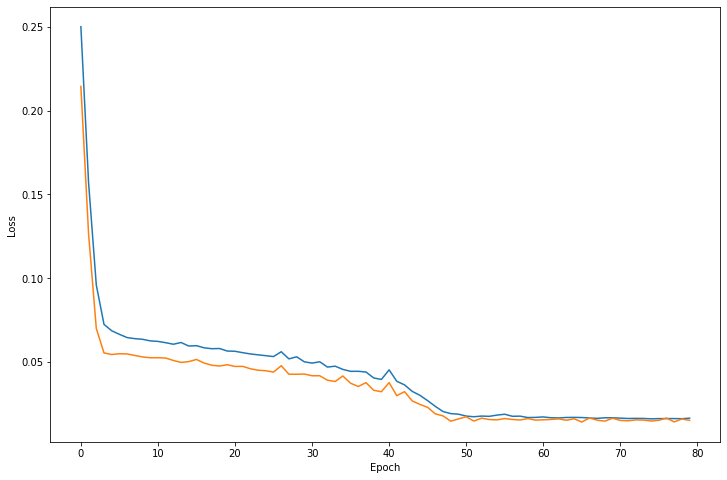

In [85]:
plt.figure(figsize = (12, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

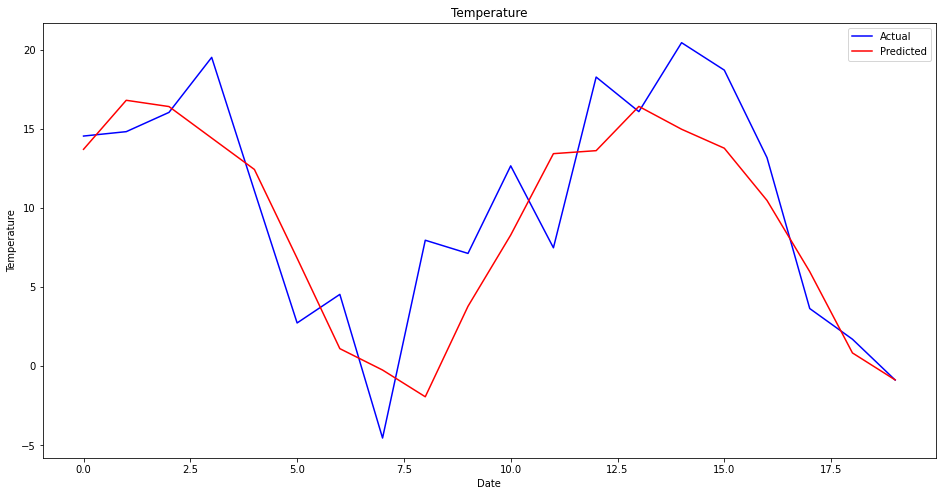

In [86]:
labels_predicted = model.predict(testing_seq)
labels_predicted = scaler.inverse_transform(labels_predicted)
plt.figure(figsize = (16, 8))
plt.plot(scaler.inverse_transform(testing_labels), color = 'blue', label = 'Actual')
plt.plot(labels_predicted , color = 'red', label = 'Predicted')
plt.title('Temperature')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.legend()
plt.show()

In [87]:
score = model.evaluate(testing_seq, testing_labels, verbose = 1)

1/1 [==============================] - 0s 29ms/step - loss: 0.0152 - mean_absolute_error: 0.1002


In [88]:
actual_labels = scaler.inverse_transform(testing_labels)

In [89]:
mape = np.mean(np.abs(labels_predicted - actual_labels) / np.abs(actual_labels))
print('MAPE: '+str(mape))

MAPE: 0.44067684
